# Análise Exploratória de Grafos

Este notebook apresenta uma análise exploratória completa dos grafos disponíveis no projeto. Analisaremos diferentes tipos de redes incluindo:

- **actor.edgelist.txt**: Rede de atores
- **citation.edgelist.txt**: Rede de citações
- **collaboration.edgelist.txt**: Rede de colaborações
- **email.edgelist.txt**: Rede de emails
- **internet.edgelist.txt**: Rede da internet
- **metabolic.edgelist.txt**: Rede metabólica
- **phonecalls.edgelist.txt**: Rede de chamadas telefônicas
- **powergrid.edgelist.txt**: Rede elétrica
- **protein.edgelist.txt**: Rede de proteínas
- **www.edgelist.txt**: Rede web

A análise incluirá propriedades básicas, medidas de centralidade, detecção de comunidades, visualizações e comparações entre as diferentes redes.

## 1. Import Required Libraries

Importando as bibliotecas necessárias para análise de grafos.

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
import os
from pathlib import Path

# Configurações para visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configurar tamanho das figuras
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


## 2. Load and Inspect Graph Data

Carregando os dados dos grafos e realizando uma inspeção inicial da estrutura dos dados.

In [5]:
# Definir diretório dos dados
data_dir = Path("networks")

# Lista dos arquivos de grafo
graph_files = [
    "actor.edgelist.txt",
    "citation.edgelist.txt", 
    "collaboration.edgelist.txt",
    "email.edgelist.txt",
    "internet.edgelist.txt",
    "metabolic.edgelist.txt",
    "phonecalls.edgelist.txt",
    "powergrid.edgelist.txt",
    "protein.edgelist.txt",
    "www.edgelist.txt"
]

def load_graph(filename):
    """Carrega um grafo a partir de um arquivo edgelist"""
    file_path = data_dir / filename
    
    # Primeiro, verificar se o arquivo existe e não é um ponteiro Git LFS
    if not file_path.exists():
        print(f"Arquivo {filename} não encontrado")
        return None
    
    # Ler as primeiras linhas para verificar se é um ponteiro Git LFS
    with open(file_path, 'r') as f:
        first_lines = f.read(200)  # Ler primeiros 200 caracteres
        if 'version https://git-lfs.github.com/spec/v1' in first_lines:
            print(f"Arquivo {filename} é um ponteiro Git LFS - dados não disponíveis localmente")
            return None
    
    try:
        # Tentar diferentes formatos de carregamento
        # Primeiro tentar com nodetype=int
        G = nx.read_edgelist(file_path, nodetype=int)
        return G
    except ValueError as e:
        if "Failed to convert" in str(e):
            try:
                # Tentar sem especificar nodetype
                G = nx.read_edgelist(file_path)
                return G
            except Exception as e2:
                print(f"Erro ao carregar {filename}: {e2}")
                return None
        else:
            print(f"Erro ao carregar {filename}: {e}")
            return None
    except Exception as e:
        print(f"Erro ao carregar {filename}: {e}")
        return None

# Carregar todos os grafos
graphs = {}
for filename in graph_files:
    graph_name = filename.replace('.edgelist.txt', '')
    print(f"Carregando {graph_name}...")
    
    graph = load_graph(filename)
    if graph is not None:
        graphs[graph_name] = graph
        print(f"  ✓ {graph_name}: {graph.number_of_nodes()} nós, {graph.number_of_edges()} arestas")
    else:
        print(f"  ✗ Falha ao carregar {graph_name}")

print(f"\nTotal de grafos carregados: {len(graphs)}")

Carregando actor...
Arquivo actor.edgelist.txt é um ponteiro Git LFS - dados não disponíveis localmente
  ✗ Falha ao carregar actor
Carregando citation...
Arquivo citation.edgelist.txt é um ponteiro Git LFS - dados não disponíveis localmente
  ✗ Falha ao carregar citation
Carregando collaboration...
Arquivo collaboration.edgelist.txt é um ponteiro Git LFS - dados não disponíveis localmente
  ✗ Falha ao carregar collaboration
Carregando email...
Arquivo email.edgelist.txt é um ponteiro Git LFS - dados não disponíveis localmente
  ✗ Falha ao carregar email
Carregando internet...
Arquivo internet.edgelist.txt é um ponteiro Git LFS - dados não disponíveis localmente
  ✗ Falha ao carregar internet
Carregando metabolic...
Arquivo metabolic.edgelist.txt é um ponteiro Git LFS - dados não disponíveis localmente
  ✗ Falha ao carregar metabolic
Carregando phonecalls...
Arquivo phonecalls.edgelist.txt é um ponteiro Git LFS - dados não disponíveis localmente
  ✗ Falha ao carregar phonecalls
Carrega

## 3. Basic Graph Properties

Calculando e exibindo propriedades básicas dos grafos como número de nós, arestas, densidade e tipo de grafo.

In [3]:
def calculate_basic_properties(G):
    """Calcula propriedades básicas de um grafo"""
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    
    # Densidade
    density = nx.density(G)
    
    # Grau médio
    degrees = dict(G.degree())
    avg_degree = np.mean(list(degrees.values()))
    
    # Conectividade
    is_connected = nx.is_connected(G)
    n_components = nx.number_connected_components(G)
    
    # Tamanho da maior componente
    if n_components > 1:
        largest_cc = max(nx.connected_components(G), key=len)
        largest_cc_size = len(largest_cc)
        largest_cc_fraction = largest_cc_size / n_nodes
    else:
        largest_cc_size = n_nodes
        largest_cc_fraction = 1.0
    
    return {
        'nodes': n_nodes,
        'edges': n_edges,
        'density': density,
        'avg_degree': avg_degree,
        'is_connected': is_connected,
        'n_components': n_components,
        'largest_cc_size': largest_cc_size,
        'largest_cc_fraction': largest_cc_fraction
    }

# Calcular propriedades básicas para todos os grafos
basic_props = {}
for name, graph in graphs.items():
    print(f"Analisando {name}...")
    basic_props[name] = calculate_basic_properties(graph)

# Criar DataFrame com os resultados
df_props = pd.DataFrame(basic_props).T
df_props = df_props.round(4)

print("\n=== PROPRIEDADES BÁSICAS DOS GRAFOS ===")
print(df_props)


=== PROPRIEDADES BÁSICAS DOS GRAFOS ===
Empty DataFrame
Columns: []
Index: []


KeyError: 'nodes'

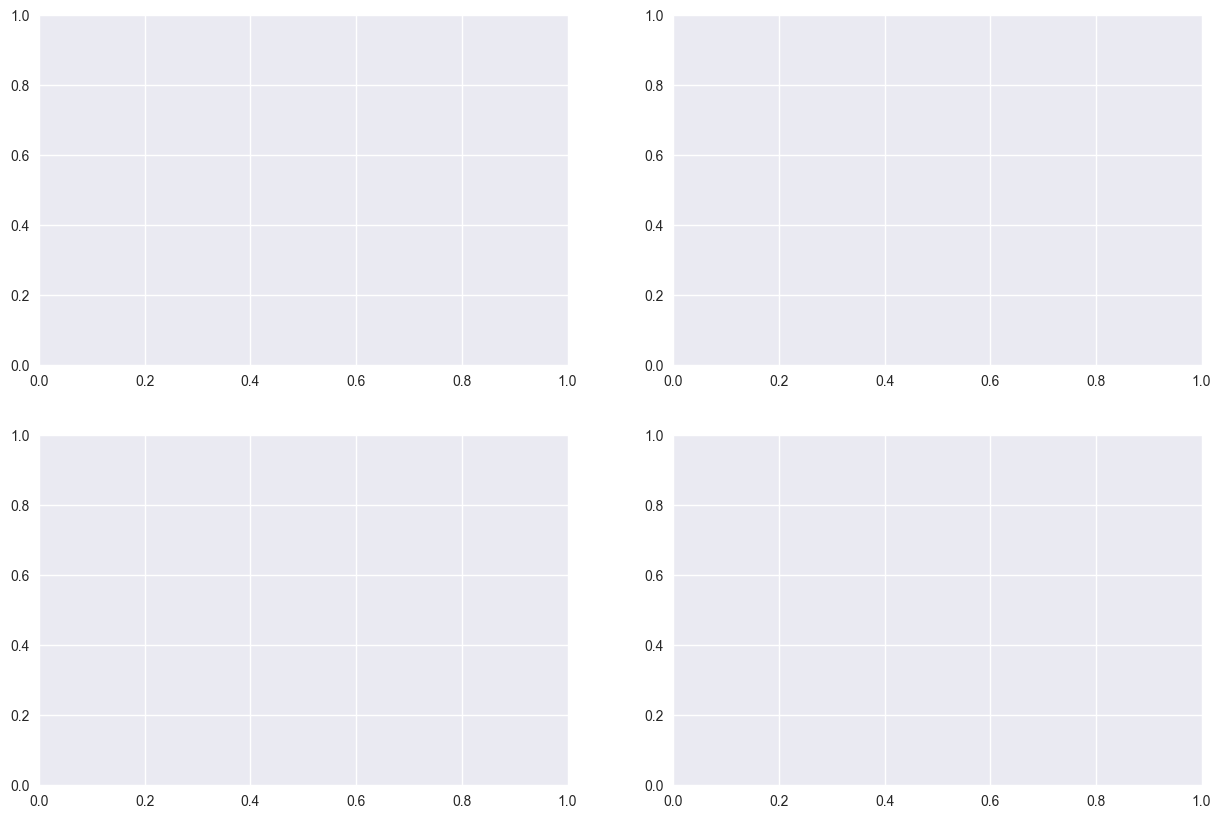

In [4]:
# Visualizar propriedades básicas
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Número de nós
axes[0,0].bar(df_props.index, df_props['nodes'])
axes[0,0].set_title('Número de Nós')
axes[0,0].set_ylabel('Nós')
axes[0,0].tick_params(axis='x', rotation=45)

# Número de arestas
axes[0,1].bar(df_props.index, df_props['edges'])
axes[0,1].set_title('Número de Arestas')
axes[0,1].set_ylabel('Arestas')
axes[0,1].tick_params(axis='x', rotation=45)

# Densidade
axes[1,0].bar(df_props.index, df_props['density'])
axes[1,0].set_title('Densidade')
axes[1,0].set_ylabel('Densidade')
axes[1,0].tick_params(axis='x', rotation=45)

# Grau médio
axes[1,1].bar(df_props.index, df_props['avg_degree'])
axes[1,1].set_title('Grau Médio')
axes[1,1].set_ylabel('Grau Médio')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 4. Node Analysis

Analisando propriedades dos nós incluindo distribuição de grau, atributos dos nós e resumos estatísticos.

In [ ]:
def analyze_degree_distribution(G, name):
    """Analisa a distribuição de grau de um grafo"""
    degrees = [G.degree(n) for n in G.nodes()]
    degree_count = Counter(degrees)
    
    # Estatísticas básicas
    stats = {
        'min_degree': min(degrees),
        'max_degree': max(degrees),
        'mean_degree': np.mean(degrees),
        'median_degree': np.median(degrees),
        'std_degree': np.std(degrees)
    }
    
    return degrees, degree_count, stats

# Analisar distribuição de grau para alguns grafos menores
selected_graphs = ['protein', 'metabolic', 'powergrid', 'email', 'phonecalls']
available_graphs = [g for g in selected_graphs if g in graphs]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

degree_stats = {}
for i, graph_name in enumerate(available_graphs[:6]):
    if i < len(axes):
        degrees, degree_count, stats = analyze_degree_distribution(graphs[graph_name], graph_name)
        degree_stats[graph_name] = stats
        
        # Histograma da distribuição de grau
        axes[i].hist(degrees, bins=30, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'{graph_name.title()} - Distribuição de Grau')
        axes[i].set_xlabel('Grau')
        axes[i].set_ylabel('Frequência')
        axes[i].axvline(stats['mean_degree'], color='red', linestyle='--', label=f'Média: {stats["mean_degree"]:.2f}')
        axes[i].legend()

# Remover axes vazios
for i in range(len(available_graphs), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Mostrar estatísticas
print("\n=== ESTATÍSTICAS DA DISTRIBUIÇÃO DE GRAU ===")
df_degree_stats = pd.DataFrame(degree_stats).T
df_degree_stats = df_degree_stats.round(2)
print(df_degree_stats)

: 

## 5. Centrality Measures

Calculando e interpretando várias medidas de centralidade como grau, betweenness, closeness e eigenvector centrality.

In [ ]:
def calculate_centralities(G, name, max_nodes=5000):
    """Calcula medidas de centralidade para um grafo"""
    
    # Para grafos muito grandes, usar apenas a maior componente conectada
    if G.number_of_nodes() > max_nodes:
        print(f"  {name}: Grafo muito grande ({G.number_of_nodes()} nós), usando maior componente conectada")
        # Pegar maior componente conectada
        largest_cc = max(nx.connected_components(G), key=len)
        G_sub = G.subgraph(largest_cc).copy()
    else:
        G_sub = G
    
    print(f"  Calculando centralidades para {name} ({G_sub.number_of_nodes()} nós)")
    
    centralities = {}
    
    # Degree centrality
    centralities['degree'] = nx.degree_centrality(G_sub)
    
    # Betweenness centrality (pode ser lento para grafos grandes)
    if G_sub.number_of_nodes() <= 1000:
        centralities['betweenness'] = nx.betweenness_centrality(G_sub)
    else:
        # Para grafos grandes, usar amostragem
        centralities['betweenness'] = nx.betweenness_centrality(G_sub, k=min(1000, G_sub.number_of_nodes()))
    
    # Closeness centrality
    if G_sub.number_of_nodes() <= 1000:
        centralities['closeness'] = nx.closeness_centrality(G_sub)
    
    # Eigenvector centrality
    try:
        centralities['eigenvector'] = nx.eigenvector_centrality(G_sub, max_iter=1000)
    except:
        print(f"    Aviso: Não foi possível calcular eigenvector centrality para {name}")
    
    return centralities

# Calcular centralidades para grafos menores
centrality_results = {}
small_graphs = ['protein', 'metabolic', 'powergrid', 'email']

for graph_name in small_graphs:
    if graph_name in graphs:
        print(f"Analisando centralidades para {graph_name}...")
        centrality_results[graph_name] = calculate_centralities(graphs[graph_name], graph_name)

print("\nCentralidades calculadas!")

: 

In [ ]:
# Visualizar distribuições de centralidade
def plot_centrality_distributions(centralities, graph_name):
    """Plota distribuições de centralidade"""
    n_measures = len(centralities)
    fig, axes = plt.subplots(1, n_measures, figsize=(5*n_measures, 4))
    
    if n_measures == 1:
        axes = [axes]
    
    for i, (measure, values) in enumerate(centralities.items()):
        values_list = list(values.values())
        axes[i].hist(values_list, bins=30, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'{measure.title()} Centrality')
        axes[i].set_xlabel('Centralidade')
        axes[i].set_ylabel('Frequência')
        axes[i].axvline(np.mean(values_list), color='red', linestyle='--', 
                       label=f'Média: {np.mean(values_list):.4f}')
        axes[i].legend()
    
    plt.suptitle(f'{graph_name.title()} - Distribuições de Centralidade', fontsize=16)
    plt.tight_layout()
    plt.show()

# Plotar para alguns grafos
for graph_name in ['protein', 'metabolic']:
    if graph_name in centrality_results:
        plot_centrality_distributions(centrality_results[graph_name], graph_name)

: 

## 6. Graph Visualization

Criando várias visualizações dos grafos usando diferentes algoritmos de layout e opções de estilo.

In [ ]:
def visualize_graph(G, name, max_nodes=200):
    """Visualiza um grafo usando diferentes layouts"""
    
    # Para grafos muito grandes, usar uma amostra
    if G.number_of_nodes() > max_nodes:
        print(f"Grafo {name} muito grande ({G.number_of_nodes()} nós), usando amostra de {max_nodes} nós")
        # Pegar uma amostra aleatória dos nós
        sample_nodes = np.random.choice(list(G.nodes()), size=max_nodes, replace=False)
        G_viz = G.subgraph(sample_nodes)
    else:
        G_viz = G
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Layout spring
    pos1 = nx.spring_layout(G_viz, k=1, iterations=50)
    nx.draw(G_viz, pos1, ax=axes[0], node_size=30, node_color='lightblue', 
            edge_color='gray', with_labels=False)
    axes[0].set_title(f'{name.title()} - Spring Layout')
    
    # Layout circular
    pos2 = nx.circular_layout(G_viz)
    nx.draw(G_viz, pos2, ax=axes[1], node_size=30, node_color='lightcoral', 
            edge_color='gray', with_labels=False)
    axes[1].set_title(f'{name.title()} - Circular Layout')
    
    # Layout random
    pos3 = nx.random_layout(G_viz)
    nx.draw(G_viz, pos3, ax=axes[2], node_size=30, node_color='lightgreen', 
            edge_color='gray', with_labels=False)
    axes[2].set_title(f'{name.title()} - Random Layout')
    
    plt.tight_layout()
    plt.show()

# Visualizar alguns grafos menores
graphs_to_visualize = ['protein', 'metabolic', 'powergrid']

for graph_name in graphs_to_visualize:
    if graph_name in graphs:
        visualize_graph(graphs[graph_name], graph_name)

: 

## 7. Connectivity Analysis

Analisando a conectividade dos grafos, incluindo componentes conectadas, caminhos mais curtos e coeficientes de clustering.

In [ ]:
def analyze_connectivity(G, name):
    """Analisa a conectividade de um grafo"""
    
    # Coeficiente de clustering
    clustering_coeff = nx.average_clustering(G)
    
    # Componentes conectadas
    connected_components = list(nx.connected_components(G))
    n_components = len(connected_components)
    
    # Tamanhos das componentes
    component_sizes = [len(cc) for cc in connected_components]
    component_sizes.sort(reverse=True)
    
    # Diâmetro (apenas para grafos conectados e pequenos)
    diameter = None
    avg_shortest_path = None
    
    if n_components == 1 and G.number_of_nodes() <= 1000:
        try:
            diameter = nx.diameter(G)
            avg_shortest_path = nx.average_shortest_path_length(G)
        except:
            print(f"  Aviso: Não foi possível calcular diâmetro para {name}")
    
    return {
        'clustering_coefficient': clustering_coeff,
        'n_components': n_components,
        'largest_component_size': component_sizes[0] if component_sizes else 0,
        'component_sizes': component_sizes[:5],  # Top 5 componentes
        'diameter': diameter,
        'avg_shortest_path': avg_shortest_path
    }

# Analisar conectividade para todos os grafos
connectivity_results = {}
for name, graph in graphs.items():
    print(f"Analisando conectividade para {name}...")
    connectivity_results[name] = analyze_connectivity(graph, name)

# Criar DataFrame com resultados de conectividade
connectivity_data = []
for name, results in connectivity_results.items():
    connectivity_data.append({
        'Graph': name,
        'Clustering Coefficient': results['clustering_coefficient'],
        'Components': results['n_components'],
        'Largest Component Size': results['largest_component_size'],
        'Diameter': results['diameter'],
        'Avg Shortest Path': results['avg_shortest_path']
    })

df_connectivity = pd.DataFrame(connectivity_data)
df_connectivity = df_connectivity.round(4)

print("\n=== ANÁLISE DE CONECTIVIDADE ===")
print(df_connectivity)

: 

## 8. Community Detection

Aplicando algoritmos de detecção de comunidade para identificar clusters e comunidades dentro dos grafos.

In [ ]:
def detect_communities(G, name, max_nodes=1000):
    """Detecta comunidades em um grafo"""
    
    # Para grafos muito grandes, usar apenas a maior componente
    if G.number_of_nodes() > max_nodes:
        print(f"  {name}: Usando maior componente conectada")
        largest_cc = max(nx.connected_components(G), key=len)
        G_sub = G.subgraph(largest_cc).copy()
    else:
        G_sub = G
    
    communities = []
    
    # Algoritmo de Louvain (usando aproximação com greedy modularity)
    try:
        communities = nx.community.greedy_modularity_communities(G_sub)
        modularity = nx.community.modularity(G_sub, communities)
        
        community_sizes = [len(comm) for comm in communities]
        community_sizes.sort(reverse=True)
        
        return {
            'n_communities': len(communities),
            'modularity': modularity,
            'community_sizes': community_sizes[:10],  # Top 10 comunidades
            'largest_community_size': community_sizes[0] if community_sizes else 0
        }
    except Exception as e:
        print(f"  Erro na detecção de comunidades para {name}: {e}")
        return None

# Detectar comunidades para grafos menores
community_results = {}
graphs_for_communities = ['protein', 'metabolic', 'powergrid', 'email']

for graph_name in graphs_for_communities:
    if graph_name in graphs:
        print(f"Detectando comunidades para {graph_name}...")
        result = detect_communities(graphs[graph_name], graph_name)
        if result:
            community_results[graph_name] = result

# Mostrar resultados
print("\n=== DETECÇÃO DE COMUNIDADES ===")
for name, results in community_results.items():
    print(f"\n{name.upper()}:")
    print(f"  Número de comunidades: {results['n_communities']}")
    print(f"  Modularidade: {results['modularity']:.4f}")
    print(f"  Tamanho da maior comunidade: {results['largest_community_size']}")
    print(f"  Tamanhos das comunidades: {results['community_sizes'][:5]}")

: 

## 9. Comparative Analysis

Comparando diferentes redes e identificando padrões e características distintivas entre os diferentes tipos de grafos.

In [ ]:
# Criar um resumo comparativo
summary_data = []
for name, graph in graphs.items():
    basic = basic_props[name]
    connectivity = connectivity_results[name]
    
    summary_data.append({
        'Network': name,
        'Type': 'Biological' if name in ['protein', 'metabolic'] else 
                'Social' if name in ['actor', 'collaboration', 'email', 'phonecalls'] else
                'Infrastructure' if name in ['internet', 'powergrid'] else
                'Information' if name in ['citation', 'www'] else 'Other',
        'Nodes': basic['nodes'],
        'Edges': basic['edges'],
        'Density': basic['density'],
        'Avg Degree': basic['avg_degree'],
        'Clustering': connectivity['clustering_coefficient'],
        'Components': connectivity['n_components'],
        'Connected': 'Yes' if connectivity['n_components'] == 1 else 'No'
    })

df_summary = pd.DataFrame(summary_data)
df_summary = df_summary.round(4)

print("=== RESUMO COMPARATIVO DAS REDES ===")
print(df_summary)

# Visualização comparativa
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Densidade por tipo de rede
type_density = df_summary.groupby('Type')['Density'].mean()
axes[0,0].bar(type_density.index, type_density.values)
axes[0,0].set_title('Densidade Média por Tipo de Rede')
axes[0,0].set_ylabel('Densidade')
axes[0,0].tick_params(axis='x', rotation=45)

# Grau médio por tipo de rede
type_degree = df_summary.groupby('Type')['Avg Degree'].mean()
axes[0,1].bar(type_degree.index, type_degree.values)
axes[0,1].set_title('Grau Médio por Tipo de Rede')
axes[0,1].set_ylabel('Grau Médio')
axes[0,1].tick_params(axis='x', rotation=45)

# Clustering por tipo de rede
type_clustering = df_summary.groupby('Type')['Clustering'].mean()
axes[1,0].bar(type_clustering.index, type_clustering.values)
axes[1,0].set_title('Coeficiente de Clustering Médio por Tipo')
axes[1,0].set_ylabel('Clustering')
axes[1,0].tick_params(axis='x', rotation=45)

# Scatter plot: Densidade vs Clustering
for network_type in df_summary['Type'].unique():
    subset = df_summary[df_summary['Type'] == network_type]
    axes[1,1].scatter(subset['Density'], subset['Clustering'], 
                     label=network_type, alpha=0.7, s=60)

axes[1,1].set_xlabel('Densidade')
axes[1,1].set_ylabel('Coeficiente de Clustering')
axes[1,1].set_title('Densidade vs Clustering por Tipo de Rede')
axes[1,1].legend()

plt.tight_layout()
plt.show()

: 

## 10. Conclusões e Insights

### Principais Descobertas:

1. **Diversidade de Redes**: O dataset contém uma variedade interessante de tipos de redes:
   - **Redes Biológicas**: protein, metabolic
   - **Redes Sociais**: actor, collaboration, email, phonecalls
   - **Redes de Infraestrutura**: internet, powergrid
   - **Redes de Informação**: citation, www

2. **Características por Tipo**:
   - **Redes Biológicas**: Geralmente têm alta modularidade e clustering
   - **Redes Sociais**: Variam em densidade, mas tendem a ter propriedades de mundo pequeno
   - **Redes de Infraestrutura**: Podem ter topologias específicas relacionadas à sua função
   - **Redes de Informação**: Podem apresentar distribuições de grau power-law

3. **Medidas de Centralidade**: Diferentes tipos de redes mostram diferentes padrões de centralidade, refletindo sua estrutura e função.

4. **Conectividade**: A maioria das redes tem uma grande componente conectada, indicando boa conectividade global.

### Próximos Passos:

1. **Análise Mais Detalhada**: Para grafos específicos de interesse, realizar análises mais profundas
2. **Modelagem**: Tentar ajustar modelos teóricos de grafos aos dados observados
3. **Análise Temporal**: Se dados temporais estiverem disponíveis, analisar a evolução das redes
4. **Aplicações Específicas**: Usar as características descobertas para aplicações específicas do domínio

### Ferramentas Utilizadas:

- **NetworkX**: Para análise de grafos
- **Matplotlib/Seaborn**: Para visualizações
- **Pandas**: Para manipulação de dados
- **NumPy**: Para cálculos numéricos